In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.linalg import expm
from datetime import datetime
import time
import scipy.sparse as sp

In [47]:
time_start = time.time()
debug = False


##FDM quantities
##Discretise space:
N = 256
x = np.linspace(-1,1,N)
dx = x[1] - x[0]
##set initial conditions
u = 2*(0.53*x + 0.47*np.sin(-1.5*np.pi*x))
u[0] = -2
u[-1] = 2
## Differentiation matrix plus identity:
D = sp.diags([1,-2,1],[-1,0,1],shape=(N,N)).toarray()/(dx**2)
I = np.eye(N)
##Linear operator L:
L = 0.01*D
L[0,:] = L[-1,:] = 0
L[0,0] = L[-1,-1] = 1


##ETD quantities

h = 1/4
M = 64

r = 15 * np.exp(1j * 2*np.pi * (np.arange(1, M+1) - 0.5) / M)

A = h * L
A[0,0] = np.log(1)
A[-1,-1] = np.log(1)
E = expm(A)
E2 = expm(A / 2)

I = np.eye(N)
Z = np.zeros((N, N))

f1 = Z.copy()
f2 = Z.copy()
f3 = Z.copy()
Q  = Z.copy()

for j in range(M):
    z = r[j]
    zIA = np.linalg.inv(z * I - A)

    Q  = Q + h * zIA * (np.exp(z/2) - 1)
    f1 = f1 + h * zIA * (-4 - z + np.exp(z)*(4 - 3*z + z**2)) / z**2
    f2 = f2 + h * zIA * (2 + z + np.exp(z)*(z - 2)) / z**2
    f3 = f3 + h * zIA * (-4 - 3*z - z**2 + np.exp(z)*(4 - z)) / z**2

Q  = np.real(Q)/M
f1 = np.real(f1)/M
f2 = np.real(f2)/M
f3 = np.real(f3)/M

uu = u.reshape(-1, 1)
tt = np.array([0.0])

tmax = 70
nmax = round(tmax / h)
nplt = int(np.floor((tmax / 20) / h))

for n in range(1, nmax + 1):
    #print("n = ", n)
    t = n * h
    
    Nu = u-u**3
    if debug:
        print("BC equals: at u", u[0], u[-1])
    
    Nu[-1] = Nu[0] = 0
    
    a  = E2 @ u + Q @ Nu
    Na = a-a**3
    
    Na[-1] = Na[0] = 0
    
    
    
    if debug:
        print("BC equals: at a", a[0], a[-1])
        
    b  = E2 @ u + Q @ Na
    Nb = b-b**3

    Nb[-1] = Nb[0] = 0

    c  = E2 @ a + Q @ (2*Nb - Nu)
    Nc = c-c**3

    Nc[-1] = Nc[0] = 0
    
    u = E @ u + f1 @ Nu + 2*f2 @ (Na + Nb) + f3 @ Nc

    if n % nplt == 0:
        #print("Saving at t = ", t)
        #u[0] = -1
        #u[-1] = 1
        uu = np.hstack((uu, u.reshape(-1, 1)))
        tt = np.append(tt, t)
        
time_end = time.time()
time_elapsed = time_end - time_start
print(f"ETD_AC execution time: {time_elapsed} seconds")

ETD_AC execution time: 0.720048189163208 seconds


In [48]:
E

array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [9.11636092e-001, 1.08377312e-003, 2.12766996e-003, ...,
        4.32813522e-125, 6.62280638e-126, 1.45005442e-126],
       [8.24355956e-001, 2.12766996e-003, 4.17803264e-003, ...,
        2.81885879e-124, 4.32813522e-125, 9.52291522e-126],
       ...,
       [9.52291522e-126, 4.32813522e-125, 2.81885879e-124, ...,
        4.17803264e-003, 2.12766996e-003, 8.24355956e-001],
       [1.45005442e-126, 6.62280638e-126, 4.32813522e-125, ...,
        2.12766996e-003, 1.08377312e-003, 9.11636092e-001],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 1.00000000e+000]])

In [49]:
uu

array([[-2.        , -2.        , -2.        , ..., -2.        ,
        -2.        , -2.        ],
       [-1.99104431, -1.86960985, -1.8696338 , ..., -1.86980163,
        -1.86980163, -1.86980163],
       [-1.98080557, -1.74611977, -1.74616858, ..., -1.74650975,
        -1.74650975, -1.74650975],
       ...,
       [ 1.98080557,  1.74611977,  1.74616858, ...,  1.74650975,
         1.74650975,  1.74650975],
       [ 1.99104431,  1.86960985,  1.8696338 , ...,  1.86980163,
         1.86980163,  1.86980163],
       [ 2.        ,  2.        ,  2.        , ...,  2.        ,
         2.        ,  2.        ]])

In [34]:
##print Q matrix as a table
print("Q matrix:")
for row in Q:
    print(" ".join(f"{val:.4f}" for val in row))
    

Q matrix:
0.1250 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.0156 0.0952 0.0129 0.0012 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.0014 0.0129 0.0964 0.0130 0.0012 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.0001 0.0012 0.0130 0.0964 0.0130 0.0012 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.0000 0.0001 0.0012 0.0130 0.0964 0.0130 0.0012 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0

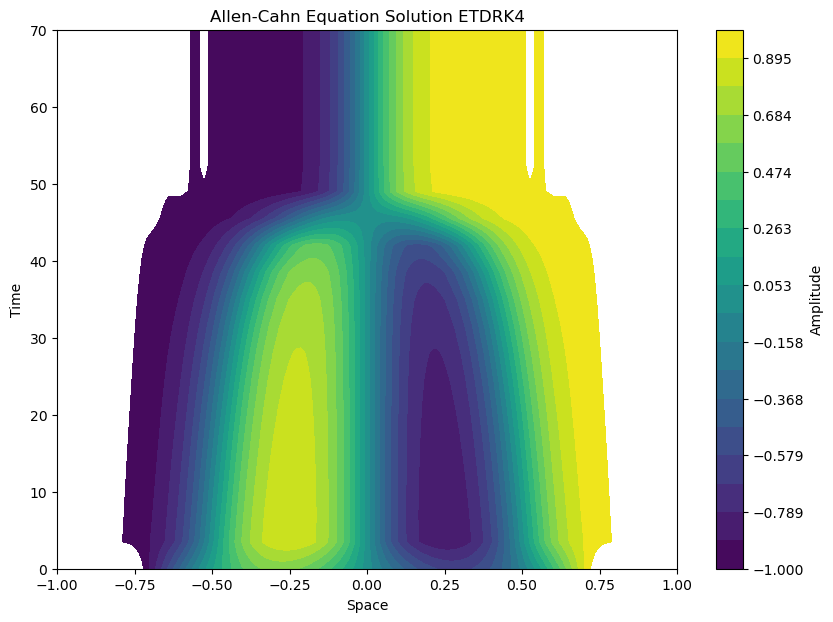

In [51]:
# Plot results using a contour plot
fig, ax = plt.subplots(figsize=(10, 7))
X, T = np.meshgrid(x, tt, indexing='ij')  # Ensure consistent indexing
contour = ax.contourf(X,T, uu[:,:], cmap=cm.viridis, levels=np.linspace(-1,1,20))  # Swap X and T to match uu's shape

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Amplitude')

# Set labels and title
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_title('Allen-Cahn Equation Solution ETDRK4')

plt.show()


In [46]:
uu[0,:]

array([-2., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1.])

In [ ]:
##Making the KS equation ETDFDM

In [41]:
x

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [139]:
N=8
D1 = sp.diags([-1,0,1],[-1,0,1],shape=(N,N)).toarray()#/(2*dx)

D2 = sp.diags([1,-2,1],[-1,0,1],shape=(N,N)).toarray()#/(dx**2)

D4 = sp.diags([1,-4,6,-4,1],[-2,-1,0,1,2], shape=(N,N)).toarray()#/(dx**4)

D1[0,-1] = -1
D1[-1,0] = D2[0,-1] = D2[-1,0] = D4[0,-2] = D4[1,-1] = D4[-2,0] = D4[-1,1]= 1
D4[-1,0] = D4[0,-1] = -4

In [141]:
D4 + D2

array([[ 4., -3.,  1.,  0.,  0.,  0.,  1., -3.],
       [-3.,  4., -3.,  1.,  0.,  0.,  0.,  1.],
       [ 1., -3.,  4., -3.,  1.,  0.,  0.,  0.],
       [ 0.,  1., -3.,  4., -3.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -3.,  4., -3.,  1.,  0.],
       [ 0.,  0.,  0.,  1., -3.,  4., -3.,  1.],
       [ 1.,  0.,  0.,  0.,  1., -3.,  4., -3.],
       [-3.,  1.,  0.,  0.,  0.,  1., -3.,  4.]])

In [ ]:
def ETDFDM_KS(N):
    time_start = time.time()

    ##FDM quantities
    ##Discretise space:
    N = 2**8
    x = 32*np.pi*np.arange(0,N)/N
    dx = x[1] - x[0]
    ##set initial conditions
    u = np.cos(x/16) * (1 + np.sin(x/16))
    ## Differentiation matrices plus identity:
    D1 = sp.diags([-1,0,1],[-1,0,1],shape=(N,N)).toarray()

    D2 = sp.diags([1,-2,1],[-1,0,1],shape=(N,N)).toarray()/(dx**2)

    D4 = sp.diags([1,-4,6,-4,1],[-2,-1,0,1,2], shape=(N,N)).toarray()/(dx**4)

    D1[0,-1] = -1
    D1[-1,0] = D2[0,-1] = D2[-1,0] = D4[0,-2] = D4[1,-1] = D4[-2,0] = D4[-1,1]= 1
    D4[-1,0] = D4[0,-1] = -4

    

    I = np.eye(N)
    ##Linear operator L:
    L = -(D2+D4)



    ##ETD quantities

    h = 1/4
    M = 64

    r = 15 * np.exp(1j *2* np.pi * (np.arange(1, M+1) - 0.5) / M)

    A = h * L
    E = expm(A)
    E2 = expm(A / 2)

    I = np.eye(N)
    Z = np.zeros((N, N))

    f1 = Z.copy()
    f2 = Z.copy()
    f3 = Z.copy()
    Q  = Z.copy()

    for j in range(M):
        z = r[j]
        zIA = np.linalg.inv(z * I - A)

        Q  = Q + h * zIA * (np.exp(z/2) - 1)
        f1 = f1 + h * zIA * (-4 - z + np.exp(z)*(4 - 3*z + z**2)) / z**2
        f2 = f2 + h * zIA * (2 + z + np.exp(z)*(z - 2)) / z**2
        f3 = f3 + h * zIA * (-4 - 3*z - z**2 + np.exp(z)*(4 - z)) / z**2

    Q  = np.real(Q)/M
    f1 = np.real(f1)/M
    f2 = np.real(f2)/M
    f3 = np.real(f3)/M

    uu = u.reshape(-1, 1)
    tt = np.array([0.0])

    tmax = 150
    nmax = round(tmax / h)
    nplt = int(np.floor((tmax / 100) / h))

    for n in range(1, nmax + 1):
        #print("n = ", n)
        t = n * h

        Nu = -u*(D1@u)
        a  = E2 @ u + Q @ Nu
        Na = -a*(D1@a)

        b  = E2 @ u + Q @ Na
        Nb = -b*(D1@b)

        c  = E2 @ a + Q @ (2*Nb - Nu)
        Nc = -c*(D1@c)

        u = E @ u + f1 @ Nu + 2*f2 @ (Na + Nb) + f3 @ Nc

        if n % nplt == 0:
            #print("Saving at t = ", t)
            uu = np.hstack((uu, u.reshape(-1, 1)))
            tt = np.append(tt, t)
            
    time_end = time.time()
    time_elapsed = time_end - time_start
    print(f"ETD_KS execution time: {time_elapsed} seconds")

    return [x, tt, uu, time_elapsed]

In [131]:
x,tt,uu,time_elapsed = ETDFDM_KS(2**8)

ETD_KS execution time: 1.0644512176513672 seconds


In [ ]:
x1,tt1,uu1,time_elapsed1 = ETDFDM_KS(2**10)


ETD_KS execution time: 0.9927809238433838 seconds


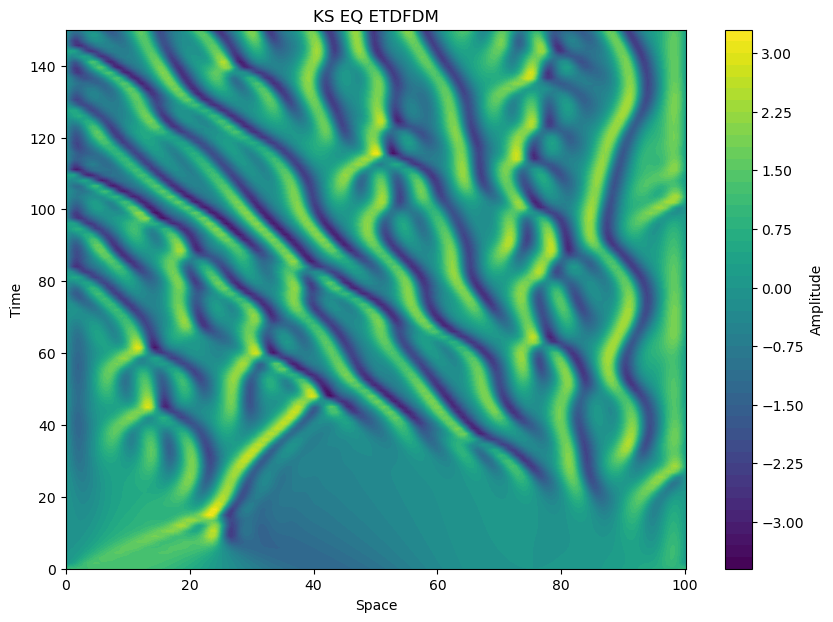

In [133]:
# Plot results using a contour plot
fig, ax = plt.subplots(figsize=(10, 7))
X, T = np.meshgrid(x, tt, indexing='ij')  # Ensure consistent indexing
contour = ax.contourf(X,T, uu[:,:], cmap=cm.viridis, levels=50)  # Swap X and T to match uu's shape

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Amplitude')

# Set labels and title
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_title('KS EQ ETDFDM')

plt.show()


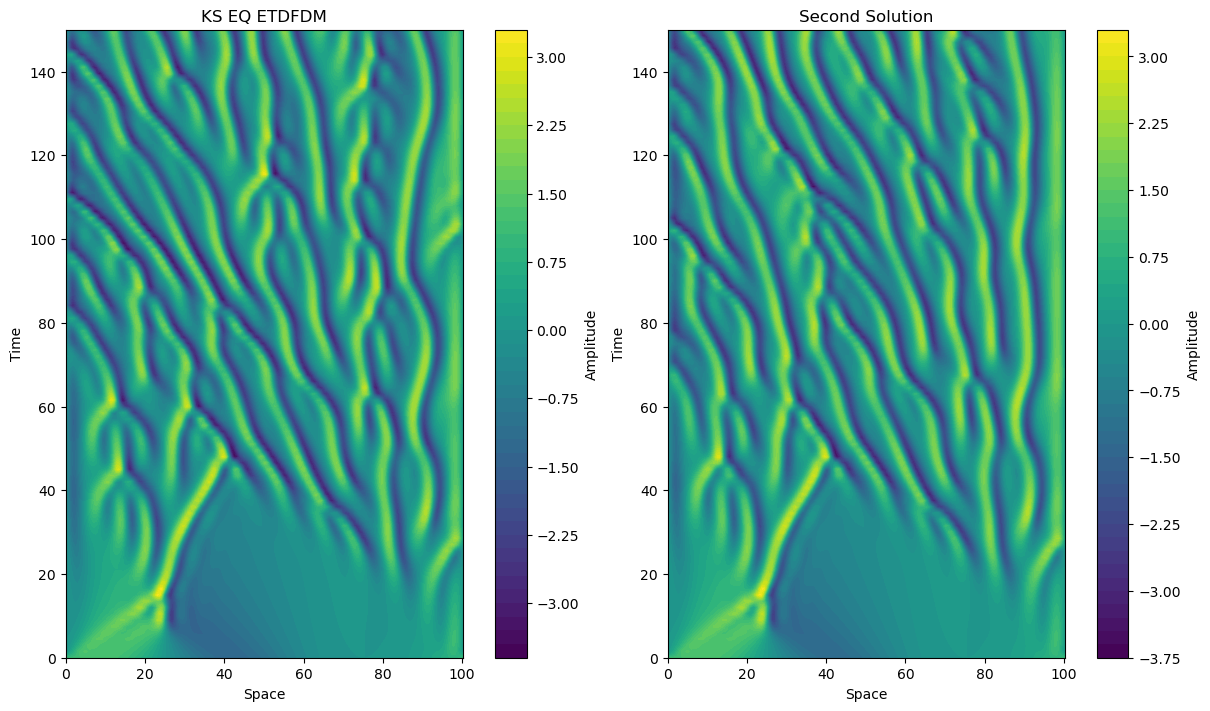

In [134]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True)

# ----- First dataset -----
X, T = np.meshgrid(x, tt, indexing='ij')
contour0 = axes[0].contourf(X, T, uu[:, :], cmap=cm.viridis, levels=50)

cbar0 = fig.colorbar(contour0, ax=axes[0])
cbar0.set_label('Amplitude')

axes[0].set_xlabel('Space')
axes[0].set_ylabel('Time')
axes[0].set_title('KS EQ ETDFDM')

# ----- Second dataset -----
X1, T1 = np.meshgrid(x1, tt1, indexing='ij')
contour1 = axes[1].contourf(X1, T1, uu1[:, :], cmap=cm.viridis, levels=50)

cbar1 = fig.colorbar(contour1, ax=axes[1])
cbar1.set_label('Amplitude')

axes[1].set_xlabel('Space')
axes[1].set_ylabel('Time')
axes[1].set_title('Second Solution')

plt.show()


In [82]:
u = np.arange(1,11)
D1 = sp.diags([-1,0,1],[-1,0,1],shape=(10,10)).toarray()
D1[0,-1] = -1
D1[-1,0] = D2[0,-1] = D2[-1,0] = D4[0,-2] = D4[1,-1] = D4[-2,0] = D4[-1,1]= 1

In [84]:
D1@u

array([-8.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2., -8.])

In [91]:
u.reshape(1,-10)

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [94]:
u*u

array([  1,   4,   9,  16,  25,  36,  49,  64,  81, 100])

In [135]:
I = np.eye(4)

In [137]:
I + 1

array([[2., 1., 1., 1.],
       [1., 2., 1., 1.],
       [1., 1., 2., 1.],
       [1., 1., 1., 2.]])